In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-201-b-mse-2-ai-b/sample_submission.csv
/kaggle/input/ai-201-b-mse-2-ai-b/train.csv
/kaggle/input/ai-201-b-mse-2-ai-b/test.csv


Train shape: (18306, 17)
Test shape: (4152, 17)
   Gender        Age    Height      Weight family_history_with_overweight  \
0    Male  33.226808  1.766888   83.337721                            yes   
1  Female  18.000000  1.600000   55.000000                            yes   
2     NaN  26.000000  1.640741  111.930700                            yes   
3    Male  19.000000  1.690000   64.000000                             no   
4    Male        NaN  1.606474   94.189167                            yes   

  FAVC  FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  TUE  \
0  NaN   2.0       NaN   Sometimes    no  1.964435  no  0.750111  0.0   
1  yes   2.0  3.000000   Sometimes    no  2.000000  no  1.000000  1.0   
2  yes   3.0  3.000000   Sometimes    no  2.617988  no  0.000000  NaN   
3  yes   2.0       NaN  Frequently    no  2.000000  no  0.000000  1.0   
4  yes   2.0  2.812283   Sometimes    no  2.000000  no  1.000000  0.0   

        CALC                 MTRANS           NObe

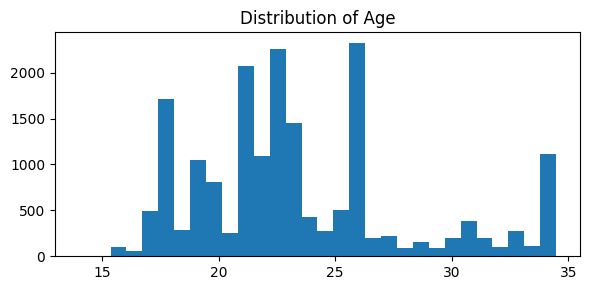

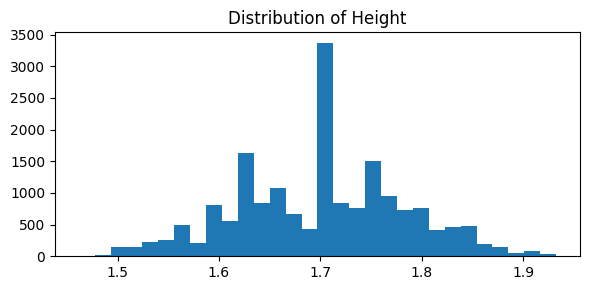

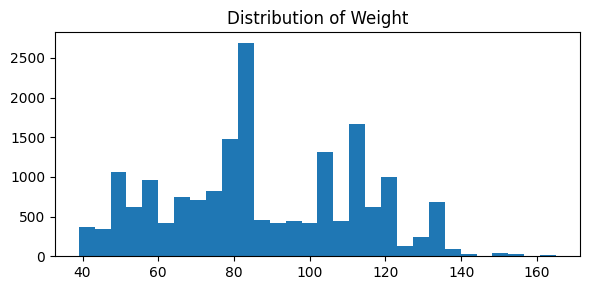

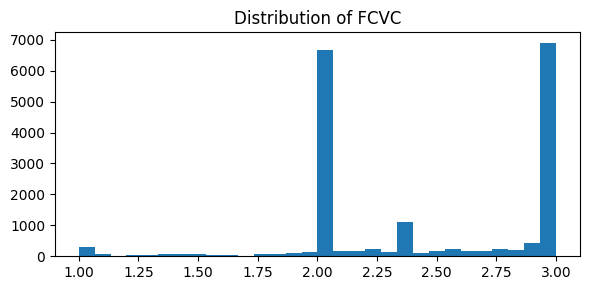

Categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
Numeric columns: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Train: (14644, 16) Val: (3662, 16)
Validation Accuracy (baseline): 0.8732932823593664

Classification report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.87      0.90       443
      Normal_Weight       0.80      0.86      0.83       544
     Obesity_Type_I       0.86      0.86      0.86       520
    Obesity_Type_II       0.95      0.95      0.95       570
   Obesity_Type_III       0.99      0.99      0.99       712
 Overweight_Level_I       0.75      0.75      0.75       434
Overweight_Level_II       0.76      0.74      0.75       439

           accuracy                           0.87      3662
          macro avg       0.86      0.86      0.86      3662
       weighted avg       0.87      0.87      0.87      3662

Fitting 3 folds fo

In [ ]:
# KIET Mid-Semester ML Competition
# End-to-end notebook-style Python script (can be used as Jupyter notebook)

# %%
# ## 1. Setup & Imports
# Run this cell first
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

# %%
# ## 2. Load Data
# Place train.csv and test.csv in the same folder as this notebook/script before running.
train_path = #'/kaggle/input/ai-201-b-mse-2-ai-b/train.csv'
test_path = #'/kaggle/input/ai-201-b-mse-2-ai-b/test.csv'

if not os.path.exists(train_path) or not os.path.exists(test_path):
    raise FileNotFoundError('Make sure train.csv and test.csv are in the working directory')

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print('Train shape:', train.shape)
print('Test shape:', test.shape)

# Quick peek
print(train.head())

# %%
# ## 3. Quick EDA
print('\nColumns:')
print(train.columns.tolist())

print('\nTarget distribution:')
print(train['NObeyesdad'].value_counts(normalize=True))

# Basic describe for numeric columns
print('\nNumeric summary:')
print(train.describe(include=[np.number]).T)

# %%
# ## 4. Missing Values
print('Missing values in train:')
print(train.isnull().sum())

print('Missing values in test:')
print(test.isnull().sum())

# If there are missing values, fill or impute. For now, assume none. If present, here's a simple strategy:
# For numeric: median; for categorical: mode

def simple_impute(df):
    for c in df.columns:
        if df[c].dtype in [np.float64, np.int64]:
            df[c] = df[c].fillna(df[c].median())
        else:
            df[c] = df[c].fillna(df[c].mode()[0])
    return df

train = simple_impute(train)
test = simple_impute(test)

# %%
# ## 5. Outlier Analysis (simple IQR method for numeric features)
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'id'] if 'id' in num_cols else num_cols

outlier_summary = {}
for c in num_cols:
    Q1 = train[c].quantile(0.25)
    Q3 = train[c].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = train[(train[c] < lower) | (train[c] > upper)]
    outlier_summary[c] = len(outliers)

print('\nOutlier counts by numeric column:')
print(outlier_summary)


# ## 5A. Outlier Treatment (IQR Clipping)

def clip_outliers_IQR(df, numeric_columns):
    df_fixed = df.copy()
    for c in numeric_columns:
        Q1 = df_fixed[c].quantile(0.25)
        Q3 = df_fixed[c].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Clip values to the allowed range
        df_fixed[c] = df_fixed[c].clip(lower, upper)

    return df_fixed

# Apply outlier clipping
train = clip_outliers_IQR(train, num_cols)
test = clip_outliers_IQR(test, num_cols)

print("\nOutliers have been clipped using IQR method.")

# Plot distributions for a few numeric columns (change as needed)
for c in num_cols[:4]:
    plt.figure(figsize=(6,3))
    plt.hist(train[c], bins=30)
    plt.title(f'Distribution of {c}')
    plt.tight_layout()
    plt.show()

# Optionally, you may clip or transform outliers. We'll proceed without aggressive removal.

# %%
# ## 6. Feature Engineering & Encoding
# Identify categorical columns (excluding target)
#@@@@@@@!!!!!!!&&&&%%%%%%$$$!!!****(((((((((((())))))))))))
TARGET = 'NObeyesdad'
all_features = [c for c in train.columns if c != TARGET]
if 'id' in all_features:
    all_features.remove('id')

cat_cols = train[all_features].select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = [c for c in all_features if c not in cat_cols]

print('Categorical columns:', cat_cols)
print('Numeric columns:', num_cols)
#!!!!!!!!!!@@@@@@@@@$$$$$$$$%%%%^^^^^^^^^^&&&&&&*******(((((_____)))))
# We'll use OneHotEncoder for nominal categorical columns. If some are ordinal, replace with OrdinalEncoder.

# %%
# ## 7. Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

# %%
# ## 8. Train/Validation Split
X = train.drop(columns=[TARGET])
y = train[TARGET]

# If id column exists, drop it from X but keep for submission mapping
if 'id' in X.columns:
    train_ids = X['id'].copy()
    X = X.drop(columns=['id'])
else:
    train_ids = None

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print('Train:', X_train.shape, 'Val:', X_val.shape)

# %%
# ## 9. Baseline Random Forest Model (with pipeline)
rf = RandomForestClassifier(random_state=RANDOM_STATE)
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf)])

pipe.fit(X_train, y_train)

# Evaluate
y_pred = pipe.predict(X_val)
print('Validation Accuracy (baseline):', accuracy_score(y_val, y_pred))
print('\nClassification report:')
print(classification_report(y_val, y_pred))

# %%
# ## 10. Hyperparameter Tuning with GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
}

cv = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
cv.fit(X_train, y_train)

print('\nBest params:', cv.best_params_)
print('Best CV score:', cv.best_score_)

best_pipe = cv.best_estimator_

# %%
# ## 11. Evaluate Best Model on Validation Set
y_val_pred = best_pipe.predict(X_val)
print('Validation Accuracy (best):', accuracy_score(y_val, y_val_pred))
print('\nClassification report:')
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix:')
print(cm)

# %%
# ## 12. Feature Importance (approximate)
# After preprocessing, feature names are transformed. We can extract feature importances for numeric + one-hot encoded cat features.

# Fit a preprocessor-only to get feature names
preprocessor_fit = preprocessor.fit(X)
# numeric names
num_features = num_cols
# categorical names after one-hot
if len(cat_cols) > 0:
    ohe = preprocessor_fit.named_transformers_['cat'].named_steps['onehot']
    ohe_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
else:
    ohe_feature_names = []

feature_names = num_features + ohe_feature_names

# Get importances from classifier
clf = best_pipe.named_steps['classifier']
importances = clf.feature_importances_

imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
print('\nTop 15 feature importances:')
print(imp_df.head(15))

# %%
# ## 13. Predict on Test Set and Create Submission
# Prepare test set
test_ids = None
if 'id' in test.columns:
    test_ids = test['id'].copy()
    X_test = test.drop(columns=['id'])
else:
    X_test = test.copy()

# Impute any missing values in test (we did earlier but safe to do again)
X_test = simple_impute(X_test)

# Predict
preds = best_pipe.predict(X_test)

# Create submission DataFrame according to required format:
# id,NObeyesdad  with id starting from 1 or using test id column if present. The sample shows id starting at 1.
if test_ids is None:
    submission = pd.DataFrame({'id': np.arange(1, len(preds) + 1), 'NObeyesdad': preds})
else:
    submission = pd.DataFrame({'id': test_ids, 'NObeyesdad': preds})

# Save submission
out_path = 'submission.csv'
submission.to_csv(out_path, index=False)
print('\nSaved submission to', out_path)
print(submission.head())

# %%
# ## 14. Notes & Next Steps
# - You can improve model performance by:
#   * More thorough EDA and feature engineering
#   * Trying other models (XGBoost, LightGBM)
#   * Using cross validation with stratified folds
#   * Trying target encoding for high-cardinality categorical features
# - Remember to also upload this notebook (.ipynb) and the submission.csv to the Google Form as required.

# End of notebook
